# 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import os
import shutil

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2

# 2. Load dataset and do some EDA

In [2]:
dataset = pd.read_csv('../data/clean_hcmc_waq.csv', delimiter=",")

In [3]:
dataset.head()

,date_time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,cloud_cover,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,us_aqi,weather_status
0,2022-10-01 07:00:00,25.511000,94.49476,24.561,31.543438,1.3,44.700000,0.179606,2.902413,209.74480,61.2,42.1,1123.0,50.80,11.50,4.0,73.652490,Light Rain
1,2022-10-01 08:00:00,26.411001,88.26100,24.311,31.320229,0.6,55.500000,0.403905,9.504272,232.69597,36.9,24.9,906.0,43.05,11.25,14.0,76.471634,Moderate Drizzle
2,2022-10-01 09:00:00,26.911001,88.03870,24.761,32.211530,0.7,46.200005,0.423807,8.788720,214.99210,28.0,18.5,598.0,31.95,10.90,27.0,77.597520,Moderate Drizzle
3,2022-10-01 10:00:00,28.011000,85.29904,25.311,33.920822,0.6,100.000000,0.555415,7.072878,194.74360,24.2,15.9,281.0,19.70,10.50,48.0,78.182625,Moderate Drizzle
4,2022-10-01 11:00:00,29.011000,78.12226,24.811,34.491055,0.4,100.000000,0.875935,7.754637,201.80147,26.0,17.1,213.0,14.25,10.50,67.0,78.430855,Light Drizzle


In [4]:
dataset.columns

Index(['date_time', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation', 'cloud_cover',
       'vapour_pressure_deficit', 'wind_speed_10m', 'wind_direction_10m',
       'pm10', 'pm2_5', 'carbon_monoxide', 'nitrogen_dioxide',
       'sulphur_dioxide', 'ozone', 'us_aqi', 'weather_status'],
      dtype='object')

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date_time                17544 non-null  object 
 1   temperature_2m           17544 non-null  float64
 2   relative_humidity_2m     17544 non-null  float64
 3   dew_point_2m             17544 non-null  float64
 4   apparent_temperature     17544 non-null  float64
 5   precipitation            17544 non-null  float64
 6   cloud_cover              17544 non-null  float64
 7   vapour_pressure_deficit  17544 non-null  float64
 8   wind_speed_10m           17544 non-null  float64
 9   wind_direction_10m       17544 non-null  float64
 10  pm10                     17544 non-null  float64
 11  pm2_5                    17544 non-null  float64
 12  carbon_monoxide          17544 non-null  float64
 13  nitrogen_dioxide         17544 non-null  float64
 14  sulphur_dioxide       

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Light Rain'),
  Text(1, 0, 'Moderate Drizzle'),
  Text(2, 0, 'Light Drizzle'),
  Text(3, 0, 'Moderate Rain'),
  Text(4, 0, 'Overcast'),
  Text(5, 0, 'Heavy Rain'),
  Text(6, 0, 'Dense Drizzle'),
  Text(7, 0, 'Partly Cloudy'),
  Text(8, 0, 'Mainly Clear'),
  Text(9, 0, 'Clear Sky')])

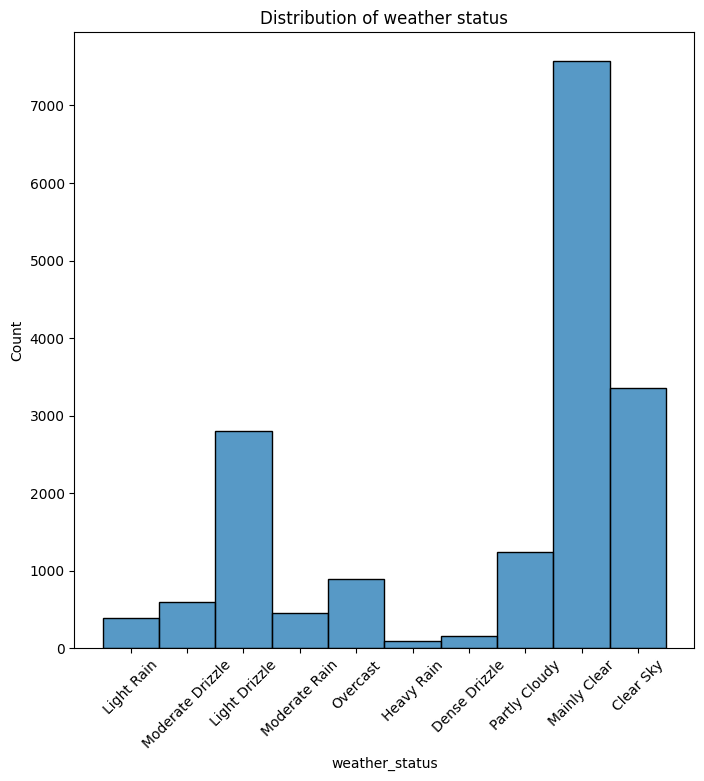

In [6]:
plt.figure(figsize=(8, 8))
sns.histplot(dataset['weather_status'])
plt.title('Distribution of weather status')
plt.xticks(rotation=45)

# 3. Preprocessing dataset

### a. Drop unnecessary features for training

In [7]:
data = dataset.drop(['date_time','weather_status'], axis=1)

### b. Visualize correlation matrix of all features

<Axes: >

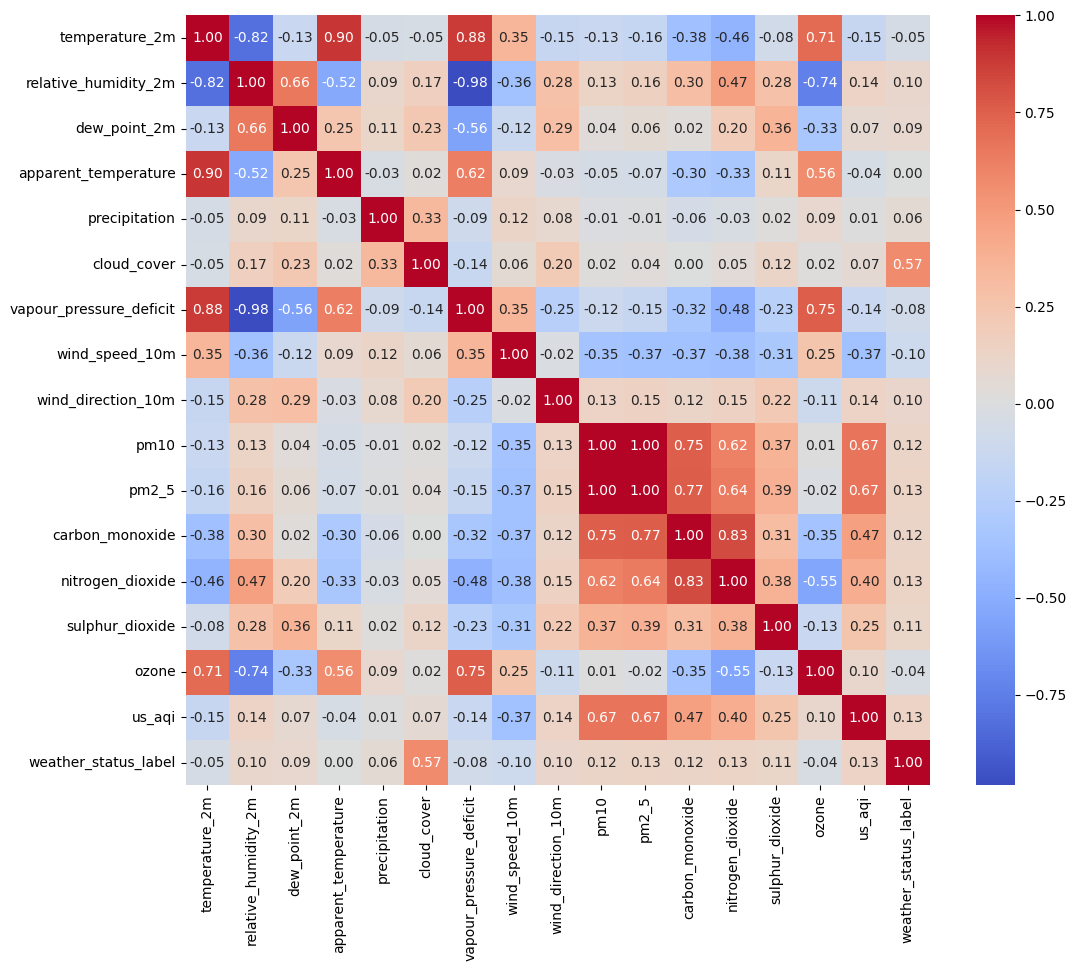

In [10]:
plt.figure(figsize=(12, 10))
correlation = data.corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm')

### c. Encode label to numerical representation

In [11]:
label_encoder = LabelEncoder()
data['weather_status_label'] = label_encoder.fit_transform(dataset['weather_status'])


### d. Extract input and output features

In [12]:
X = data.drop('weather_status_label', axis=1)
y = data['weather_status_label']

### e. Standardize the features in X as they have different scales and units (can be seen in the below box plot).


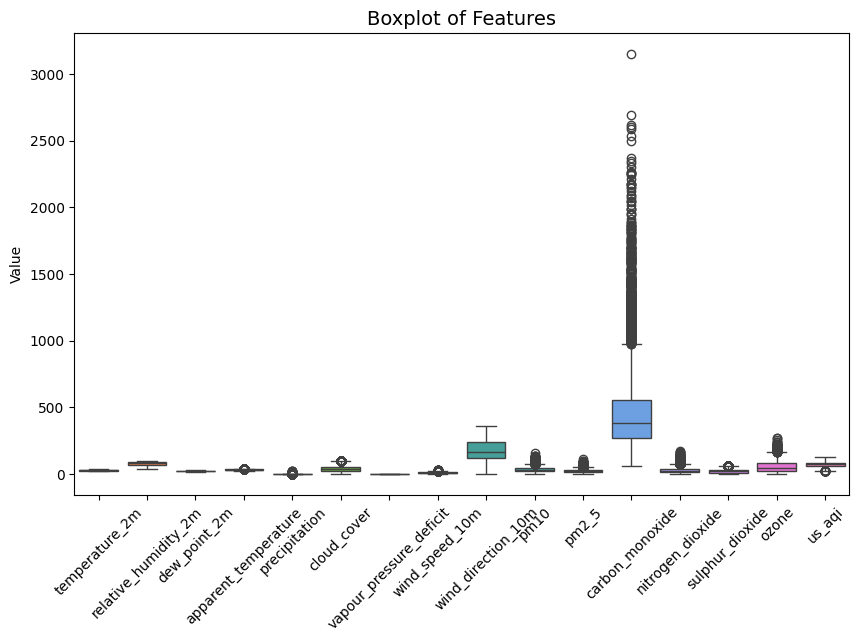

In [13]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=X)
plt.title('Boxplot of Features', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Value')
plt.show()

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

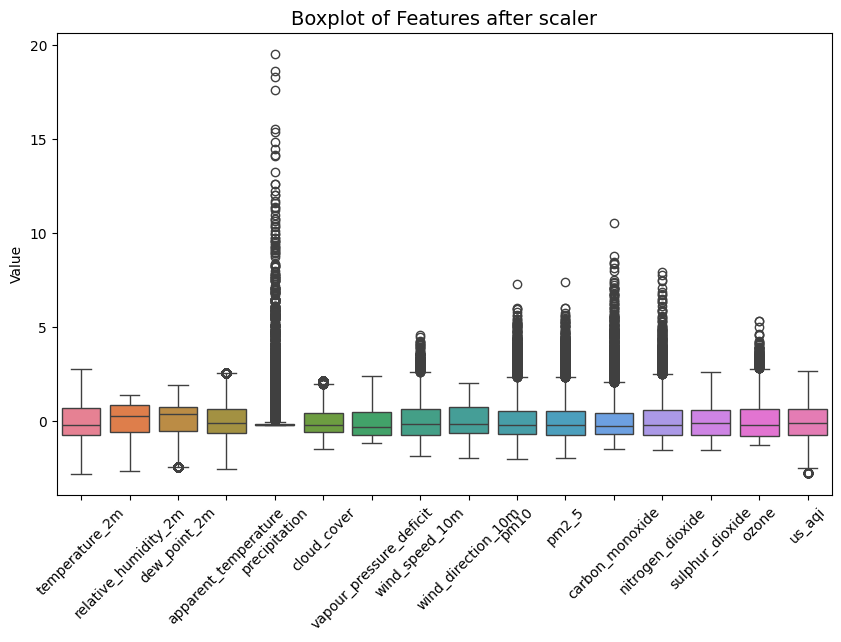

In [15]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=X_scaled)
plt.title('Boxplot of Features after scaler', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Value')
plt.show()

### f. Select top best features based on scoring function "chi2".

In [16]:
selector = SelectKBest(chi2, k=10)  # top 10 best
X_new = selector.fit_transform(X, y)


In [17]:
selected_features = X.columns[selector.get_support()]
selected_features

Index(['precipitation', 'cloud_cover', 'wind_direction_10m', 'pm10', 'pm2_5',
       'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide', 'ozone',
       'us_aqi'],
      dtype='object')

### g. Split train and test set

In [18]:
# Train: 80%, TestL 20%
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 4. Do some experiments on training several models to classify the weather status

### a. Train with all the features with Decision Tree Algorithm

In [19]:
# Initialize the model and fit the model into the dataset
model = DecisionTreeClassifier(criterion='gini', random_state=42)
model.fit(X_train, y_train)

# Do predictions on test set
y_pred = model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       671
           1       1.00      1.00      1.00        32
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00       559
           4       1.00      1.00      1.00        79
           5       1.00      1.00      1.00      1513
           6       0.99      1.00      1.00       120
           7       1.00      0.99      0.99        90
           8       1.00      1.00      1.00       180
           9       1.00      1.00      1.00       247

    accuracy                           1.00      3509
   macro avg       1.00      1.00      1.00      3509
weighted avg       1.00      1.00      1.00      3509



### b. Train with all the features with Random Forest Algorithm

In [20]:
# Initialize the model and fit the model into the dataset
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Do predictions on test set
y_pred = model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       671
           1       0.90      0.59      0.72        32
           2       1.00      0.61      0.76        18
           3       1.00      1.00      1.00       559
           4       0.86      0.95      0.90        79
           5       1.00      1.00      1.00      1513
           6       0.98      1.00      0.99       120
           7       0.92      0.98      0.95        90
           8       1.00      1.00      1.00       180
           9       1.00      1.00      1.00       247

    accuracy                           0.99      3509
   macro avg       0.97      0.91      0.93      3509
weighted avg       0.99      0.99      0.99      3509



### c. Train with top 10 features with Decision Tree Algorithm

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled[selected_features], y, test_size=0.2, random_state=42, stratify=y)

# Initialize the model and fit the model into the dataset
model = DecisionTreeClassifier(criterion='gini', random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Do predictions on test set
y_pred = model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       671
           1       1.00      1.00      1.00        32
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00       559
           4       1.00      1.00      1.00        79
           5       1.00      1.00      1.00      1513
           6       1.00      1.00      1.00       120
           7       1.00      1.00      1.00        90
           8       1.00      1.00      1.00       180
           9       1.00      1.00      1.00       247

    accuracy                           1.00      3509
   macro avg       1.00      1.00      1.00      3509
weighted avg       1.00      1.00      1.00      3509



### d. Train with top 10 features with Random Forest Algorithm

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled[selected_features], y, test_size=0.2, random_state=42, stratify=y)

# Initialize the model and fit the model into the dataset
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Do predictions on test set
y_pred = model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       671
           1       0.93      0.81      0.87        32
           2       1.00      0.89      0.94        18
           3       1.00      1.00      1.00       559
           4       0.93      0.97      0.95        79
           5       1.00      1.00      1.00      1513
           6       1.00      1.00      1.00       120
           7       0.98      0.99      0.98        90
           8       1.00      1.00      1.00       180
           9       1.00      1.00      1.00       247

    accuracy                           1.00      3509
   macro avg       0.98      0.97      0.97      3509
weighted avg       1.00      1.00      1.00      3509



### e. Due to the imbalance in the number of samples among labels, use technique (SMOTE) to balance samples. This may help model predict equally better in all classes.

In [23]:
# Use SMOTE to balance samples
X_train, X_test, y_train, y_test = train_test_split(X_scaled[selected_features], y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check distribution of classes
print("Class distribution after SMOTE:")
print(y_train_resampled.value_counts())

Class distribution after SMOTE:
weather_status_label
3    6054
9    6054
8    6054
5    6054
7    6054
0    6054
4    6054
1    6054
6    6054
2    6054
Name: count, dtype: int64


#### i. Decision Tree Algorithm

In [24]:
# Initialize the model and fit the model into the dataset
model = DecisionTreeClassifier(criterion='gini', random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Do predictions on test set
y_pred = model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       671
           1       1.00      1.00      1.00        32
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00       559
           4       1.00      1.00      1.00        79
           5       1.00      1.00      1.00      1513
           6       1.00      1.00      1.00       120
           7       1.00      1.00      1.00        90
           8       1.00      1.00      1.00       180
           9       1.00      1.00      1.00       247

    accuracy                           1.00      3509
   macro avg       1.00      1.00      1.00      3509
weighted avg       1.00      1.00      1.00      3509



#### ii. Random Forest Algorithm

In [25]:
# Initialize the model and fit the model into the dataset
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Do predictions on test set
y_pred = model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       671
           1       1.00      0.97      0.98        32
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00       559
           4       0.99      1.00      0.99        79
           5       1.00      1.00      1.00      1513
           6       1.00      0.99      1.00       120
           7       1.00      0.99      0.99        90
           8       1.00      1.00      1.00       180
           9       1.00      1.00      1.00       247

    accuracy                           1.00      3509
   macro avg       1.00      0.99      1.00      3509
weighted avg       1.00      1.00      1.00      3509



<div style="background-color:#E6F9E6; padding: 20px; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border:2px solid #66C2A5; margin-top: 20px;">
    <h1 style="font-size:28px; font-family:Georgia, serif; color:#66C2A5; text-align: center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.2);">
        Conclusion
    </h1>
    <p style="font-size:22px; font-family:Georgia, serif; line-height: 1.5em; text-indent: 20px; color:#333;">
        After doing some training on several models and trying some techniques such as 
        <span style="color:#66C2A5;"><b>SelectKBest</b></span> for feature selection and 
        <span style="color:#66C2A5;"><b>SMOTE</b></span> for balancing the dataset, the 
        <span style="color:#66C2A5;"><b>Decision Tree algorithm</b></span> turns out to be the most suitable and powerful for this task.
    </p>
    <p style="font-size:22px; font-family:Georgia, serif; line-height: 1.5em; text-indent: 20px; color:#333;">
        This can be clearly seen in the classification report of each model, showcasing the robustness and accuracy of the Decision Tree approach in handling the dataset effectively.
    </p>
</div>


# 5. Hyperparameters Tuning

### - After many experiments, DecisionTreeClassfier performs almost perfectly in this task with the help of some techniques. Therefore, in this part, we will do some hyperparameters tuning to see whether RandomForestClassifier can be improved or not

#### a. GridSearchCV for small number of combinations

In [95]:
param_grid = {'n_estimators': [100, 150],
              'max_depth': [5, 10],
              'min_samples_split': [5, 10, 20]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid, 
                           cv=5, verbose=1, n_jobs=-1, scoring='f1_weighted', refit=True)
grid_search.fit(X_train_resampled, y_train_resampled)
print("Best parameters: {}".format(grid_search.best_params_))
y_predict = grid_search.predict(X_test)
print(classification_report(y_test, y_predict))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\loc11\OneDrive - VNU-HCMUS\hcmus\DS\Project\HCMC-WAQ-Analysis\capydata_env\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       671
           1       1.00      0.94      0.97        32
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00       559
           4       0.98      1.00      0.99        79
           5       1.00      1.00      1.00      1513
           6       1.00      1.00      1.00       120
           7       1.00      0.99      0.99        90
           8       1.00      1.00      1.00       180
           9       1.00      1.00      1.00       247

    accuracy                           1.00      3509
   macro avg       1.00      0.99      0.99      3509
weighted avg       1.00      1.00      1.00      3509



# 6. Retraining pipeline with the best model and save needed configuration to make prediction pipeline


In [47]:
type(selected_features.tolist())

list

In [48]:
# 1.Read dataset
dataset = pd.read_csv('../data/clean_hcmc_waq.csv', delimiter=",")
# 2.Preprocessing
data = dataset.drop(['date_time','weather_status'], axis=1)
# 2.1.Label encode
label_encoder = LabelEncoder()
data['weather_status_label'] = label_encoder.fit_transform(dataset['weather_status'])
# 2.2.Extract X,y
X = data.drop('weather_status_label', axis=1)
y = data['weather_status_label']
# 2.3.Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[selected_features])
X_scaled = pd.DataFrame(X_scaled, columns=selected_features.tolist())
# 3. Feature engineering
# 3.1. Best features selection
selector = SelectKBest(chi2, k=10)  
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
# 5. Balance dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# 6. Model training
# 6.1.Initialize Decision Tree class from sklearn
best_model = DecisionTreeClassifier(criterion='gini', random_state=42)
# 6.2.Fit the model into the dataset
best_model.fit(X_train_resampled, y_train_resampled)
# 7. Evaluation
# 7.1.Do predictions on test set
y_pred = best_model.predict(X_test)
# 7.2.Print different metrics for classification task
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       671
           1       1.00      1.00      1.00        32
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00       559
           4       1.00      1.00      1.00        79
           5       1.00      1.00      1.00      1513
           6       1.00      1.00      1.00       120
           7       1.00      1.00      1.00        90
           8       1.00      1.00      1.00       180
           9       1.00      1.00      1.00       247

    accuracy                           1.00      3509
   macro avg       1.00      1.00      1.00      3509
weighted avg       1.00      1.00      1.00      3509



In [49]:
# Create 'model' folder to save config
model_folder = '../model'

if os.path.exists(model_folder):
    shutil.rmtree(model_folder)
os.makedirs(model_folder, exist_ok=True)

# Save scaler
scaler_path = os.path.join(model_folder, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
# Save label encoder
label_encoder_path = os.path.join(model_folder, 'label_encoder.pkl')
joblib.dump(label_encoder, label_encoder_path)
# Save model
model_path = os.path.join(model_folder, 'classification.pkl')
joblib.dump(best_model, model_path)

['../model\\classification.pkl']

# 7. Pridicting Pipeline

In [51]:
loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)
label_encoder = joblib.load(label_encoder_path)

# Sample data
input_data = {
    'precipitation': [0.0],
    'cloud_cover': [10.0],
    'wind_direction_10m': [180.0],
    'pm10': [20.0],
    'pm2_5': [10.0],
    'carbon_monoxide': [0.2],
    'nitrogen_dioxide': [10.0],
    'sulphur_dioxide': [0.005],
    'ozone': [30.0],
    'us_aqi': [50.0]
}

input_df = pd.DataFrame(input_data)
input_scaled = loaded_scaler.transform(input_df)
predictions = loaded_model.predict(input_scaled)
print("Dự đoán weather status:", label_encoder.inverse_transform(predictions))

Dự đoán weather status: ['Clear Sky']


c:\Users\loc11\OneDrive - VNU-HCMUS\hcmus\DS\Project\HCMC-WAQ-Analysis\capydata_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [52]:
import gradio as gr

loaded_model = joblib.load(model_path)
label_encoder = joblib.load(label_encoder_path)


def predict_pipeline(precipitation, cloud_cover, wind_direction_10m, pm10, pm2_5,
                     carbon_monoxide, nitrogen_dioxide, sulphur_dioxide, ozone, us_aqi):
    # Prepare input data as a DataFrame
    input_data = {
        'precipitation': [precipitation],
        'cloud_cover': [cloud_cover],
        'wind_direction_10m': [wind_direction_10m],
        'pm10': [pm10],
        'pm2_5': [pm2_5],
        'carbon_monoxide': [carbon_monoxide],
        'nitrogen_dioxide': [nitrogen_dioxide],
        'sulphur_dioxide': [sulphur_dioxide],
        'ozone': [ozone],
        'us_aqi': [us_aqi]
    }
    input_df = pd.DataFrame(input_data)
    input_df = loaded_scaler.transform(input_df)
    # Make prediction
    prediction = loaded_model.predict(input_df)

    # Return the decoded label
    return label_encoder.inverse_transform(prediction)[0]

demo = gr.Interface(
    fn=predict_pipeline,
    inputs=["number","number","number","number","number","number","number","number","number","number"],
    outputs="text"
)
demo.launch()

c:\Users\loc11\OneDrive - VNU-HCMUS\hcmus\DS\Project\HCMC-WAQ-Analysis\capydata_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler features", StandardScaler(), ["","",""]),
    ("weather_status", OneHotEncoder(), ["weather_status"]),
])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', tenmodel() )])
model.fit(X_train, y_train)